### Weather Trend Forecasting
In this notebook I explore, analyze, and perform predictive modeling on weather data from the World Weather Repository found on Kaggle.

This report was created during the application process for the PMAccelerator Software Engineer Bootcamp. PMAccelerator has the following mission: 

"By making industry-leading tools and education available to individuals from all backgrounds, we level the playing field for future PM leaders. This is the PM Accelerator motto, as we grant aspiring and experienced PMs what they need most – Access. We introduce you to industry leaders, surround you with the right PM ecosystem, and discover the new world of AI product management skills."


In [2]:
'''
Import important libraries
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from mpl_toolkits.basemap import Basemap
from itertools import chain

##### Load Data

The data is available as a csv file at https://www.kaggle.com/datasets/nelgiriyewithana/global-weather-repository/data. The first step in my analysis is to load in the dataset (as downloaded to this repository), and observe its features. 

In [3]:
'''
Load in and examine data
'''
data = pd.read_csv('GlobalWeatherRepository.csv')
display(data.head())
print(f"The dataset contains the following columns: {list(data.columns)}")

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


The dataset contains the following columns: ['country', 'location_name', 'latitude', 'longitude', 'timezone', 'last_updated_epoch', 'last_updated', 'temperature_celsius', 'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination']


##### Data Cleaning and Pre-processing

As an initial data cleaning step, it is important to indentify and remove missing (NaN) values. However, there are luckily no missing values in this set that need to be removed. 

In [4]:
'''
Confirm that there are no missing values
'''
og_len = len(data)
data = data.dropna()
print(f"Removed {og_len - len(data)} rows with missing data")

Removed 0 rows with missing data


Next, I will remove any obvious outliars in the data. As a good starting point, I chose to indentify outliars as values more than 4 standard deviations away from feature means. 

In [5]:
'''
Remove outliars 
'''
z_threshold = 4
numerical_cols = data.select_dtypes(include=[np.float64, np.int64]).columns
for col in numerical_cols:
      zscore = (data[col] - data[col].mean()) / data[col].std()
      keep_idxs = np.abs(zscore) < z_threshold
      data = data[keep_idxs]
print(f"Removed {og_len - len(data)} rows with outliars ({np.round(100*(og_len - len(data))/og_len, 2)}% of data)") 

Removed 4805 rows with outliars (10.06% of data)


It is important to note that since I did not have to drop any rows due to missing data, dropping rows with outliars should still result in a dataset with a reasonable number of rows. Infact, we still retain around 90% of the initial dataset. If this were not the case, I would consider filling in the outliars with mean column values

To use this data for predictive modeling, it is important to normalize feature columns so that our model does not put undue empahsis on features that happen to have larger mean values. I chose to use z-score normalization, but other methods could be used. I perform this normalization after outliar removal to ensure that the normalization is not skewed by outliars

In [6]:
'''
Normalize each column
'''
data_norm = data.copy()
for col in numerical_cols:
    data_norm[col] = (data[col] - data[col].mean()) / data[col].std()

##### Exploratory Data Analysis

Before moving forward with any model building, we should get a better sense of the data by vizualizing important trends and correlations. First, I will plot the distributions of each feature. 

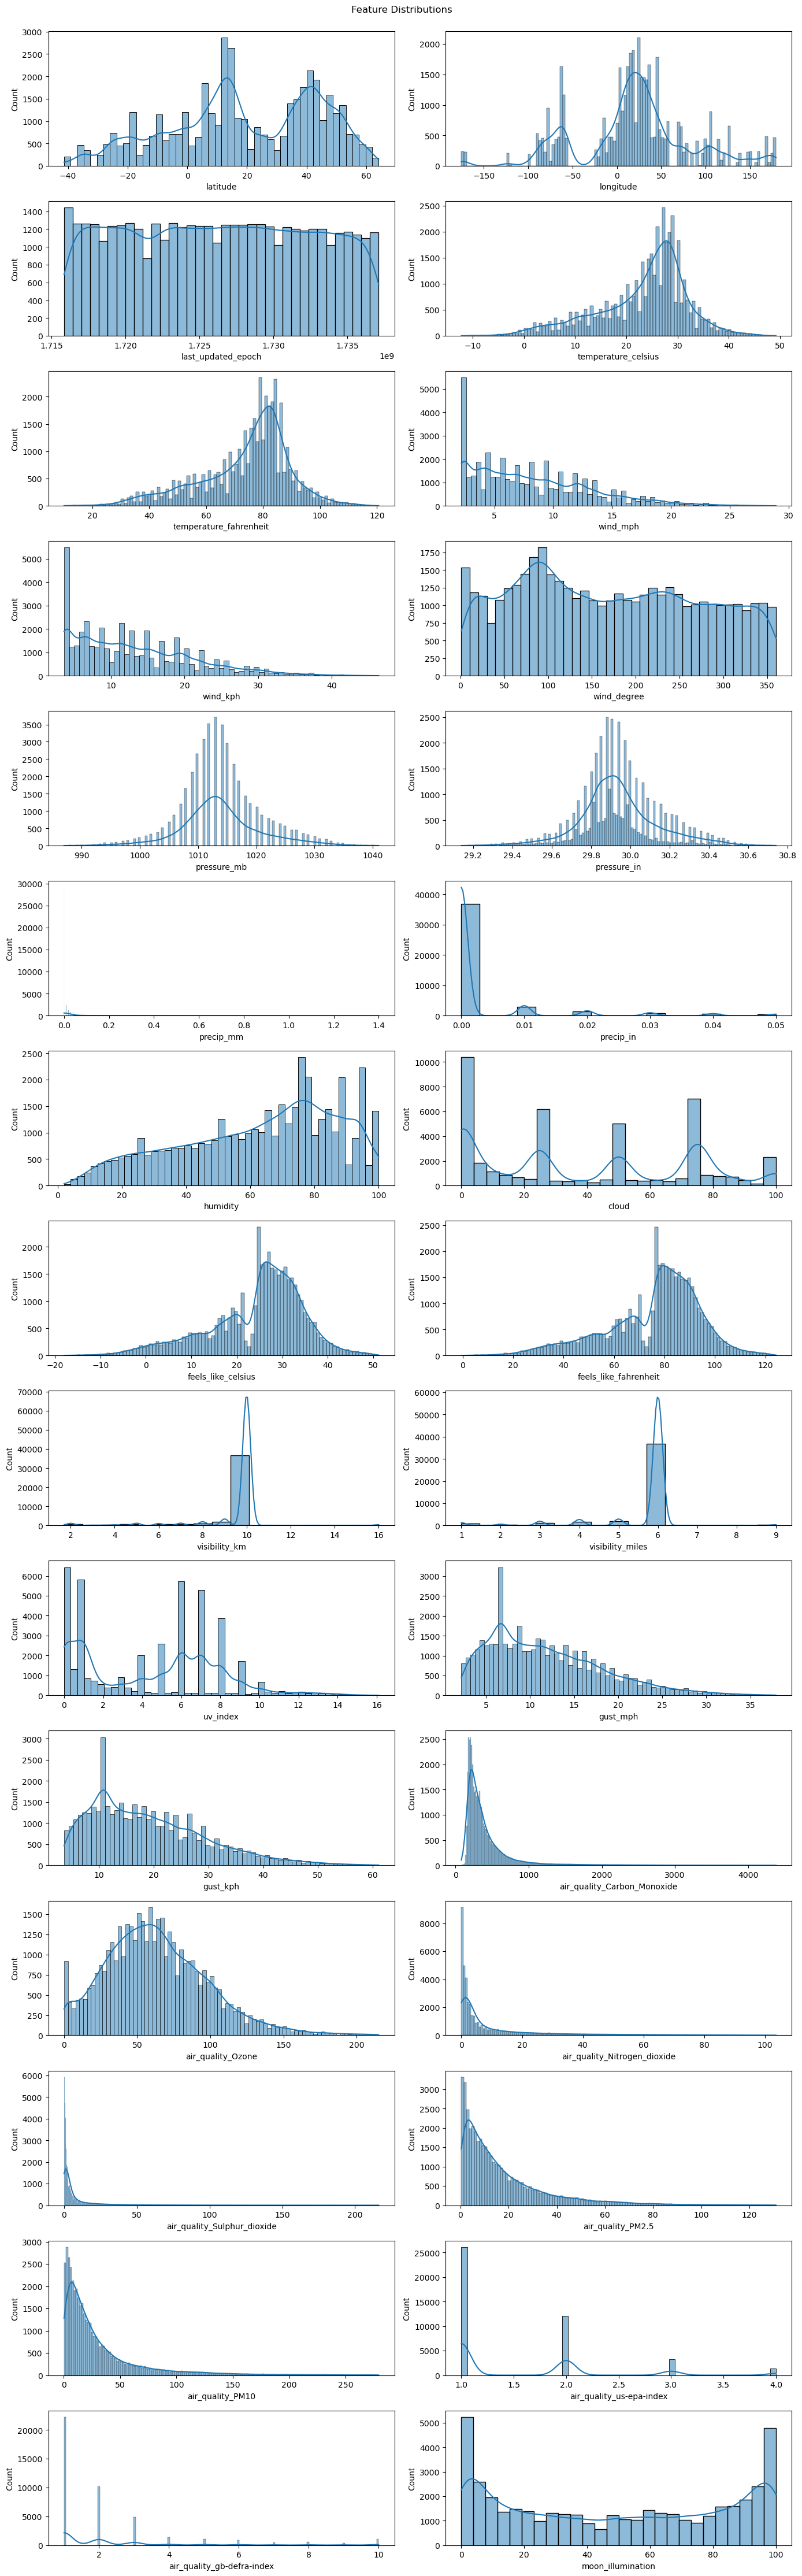

In [7]:
'''
Explore Feature Distributions (Normalized Data)
'''
fig = plt.figure(figsize=(14, len(numerical_cols)*3))
plt.suptitle('Feature Distributions')
for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 2, idx)
    sns.histplot(data[col], kde=True)
plt.tight_layout()
fig.subplots_adjust(top=0.975)

The above plots reveal some interesting facts about our features.
* There is a strong skew in the number of measurements taken from locations in the Northern hemisphere and Southern hemispheres, with notable peaks at ~10 to 20 degrees North and ~30 - 60 degrees North.
* The latitute distribution is an even clearer double-peaked Guassian, with peaks at -100 to -50 degrees and -25 to 50 degrees.
* Wind, percipitation, and air quality are all heavily skewed towards small values, with distinct tails trailing off towards higher values.
* Temperature and pressure measurements are highly Guassian

It is also clear that some features have very similar distributions. We can see this more clearly by plotting a correlatin matrix.

<AxesSubplot:title={'center':'Feature Correlations'}>

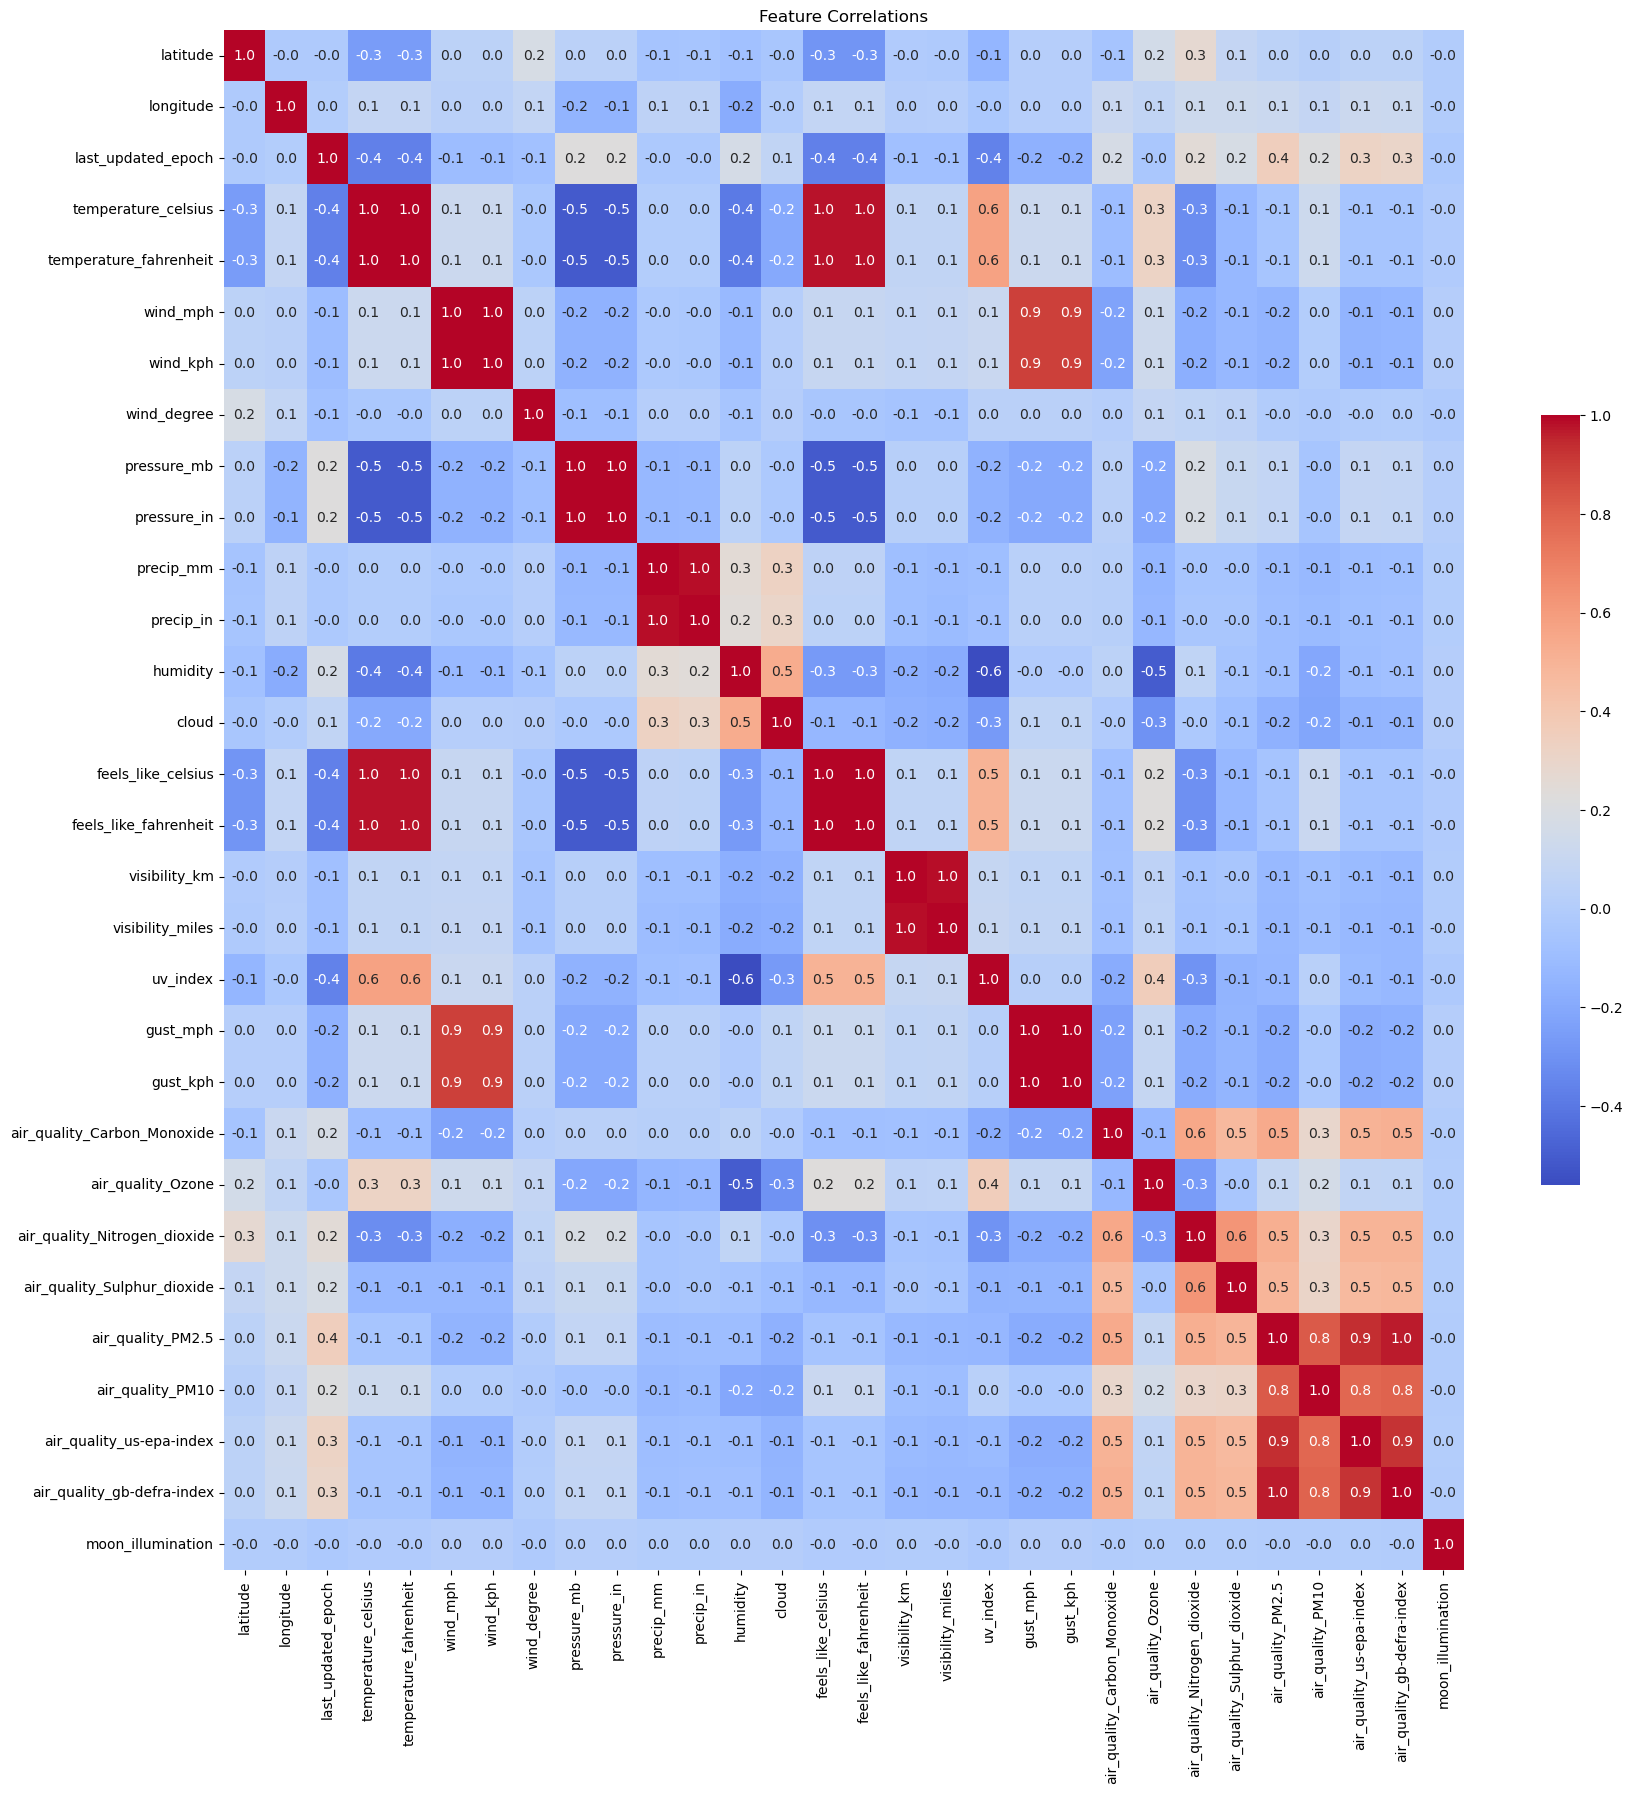

In [8]:
'''
Plot feature correlations
'''
corr = data[numerical_cols].corr()
fig = plt.figure(figsize=(20, 20))
plt.title('Feature Correlations')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f", cbar_kws={"shrink": 0.5})

From the above, I note strong correlation between multiple sets of features. 
* As expected, features that measure the same quantity (and vary only in units) have perfect correlation. These include the celcius and farenheit temperature measurements, the mph and kph wind measurements, the mph and kph gust measurements, the mm and inches percipitation measurements, the km and miles visibility measurements, and the mb and inches pressure measurements.  
* There is also strong correlation between the different air quality features.

To improve model efficiency and reduce changes of overfitting to sets of correlated features, I will remove the non-metric measurement duplicates. I will further reduce redundancy by keeping only one air quality index; I choose 'air_quality_us-epa-index'. 

In [9]:
'''
Remove highly correlated features
'''
data = data.drop(columns=['temperature_fahrenheit', 'wind_mph', 'gust_mph', 'precip_in', 'pressure_in', 'visibility_miles'])


Because each observation is associated with a latitude and longitude, I can further explore trends by creating geospatial maps of various measurements.

/tmp/ipykernel_11751/3767032046.py:35: RuntimeWarning: divide by zero encountered in log10
  m.scatter(lon, lat, latlon=True, c=np.log10(precip), cmap='Blues', s=7)


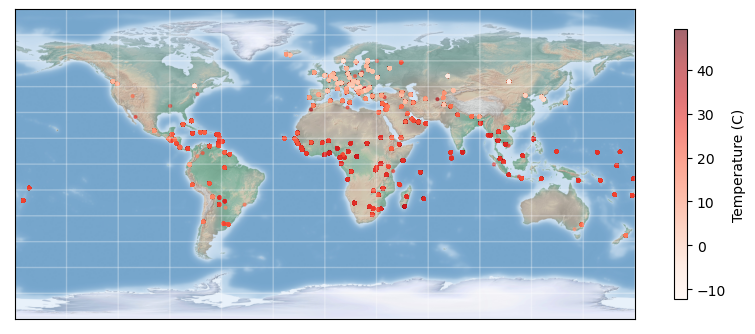

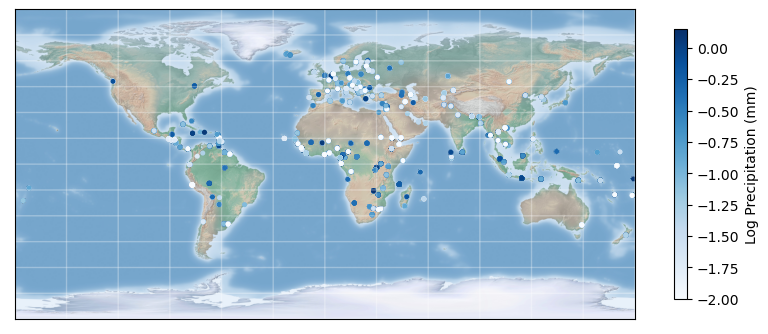

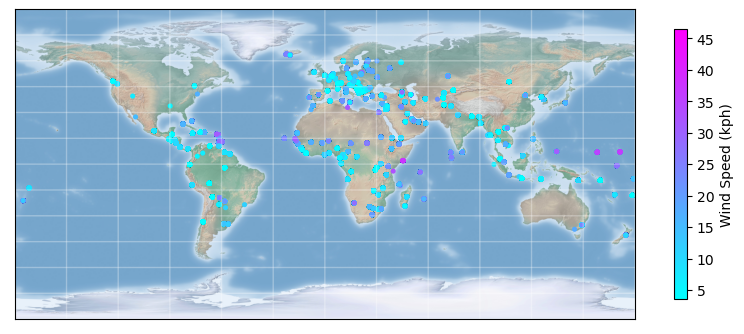

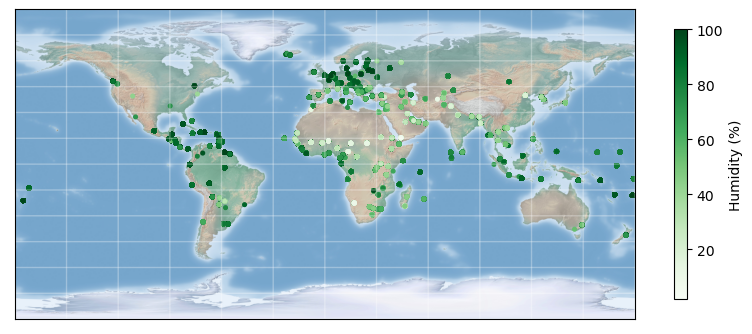

In [10]:
'''
Create spatial maps of temperature, precipitation, wind speed, and humidity
'''

# Extract relevant columns
lat = data['latitude'].values
lon = data['longitude'].values
temp = data['temperature_celsius'].values
precip = data['precip_mm'].values
wind = data['wind_kph'].values
humidity = data['humidity'].values

# Function to draw a shaded-relief image (credit: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html)
def draw_map(m, scale=0.2):
    m.shadedrelief(scale=scale)
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

# Plot temperature
fig = plt.figure(figsize=(10, 7), edgecolor='w')
m = Basemap(projection='cyl', resolution=None, llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)
m.scatter(lon, lat, latlon=True, c=temp, cmap='Reds', s=4, alpha=0.6)
plt.colorbar(label='Temperature (C)', shrink=0.5)

# Plot precipitation
fig = plt.figure(figsize=(10, 7), edgecolor='w')
m = Basemap(projection='cyl', resolution=None, llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)
m.scatter(lon, lat, latlon=True, c=np.log10(precip), cmap='Blues', s=7)
plt.colorbar(label='Log Precipitation (mm)', shrink=0.5)

# Plot wind speed
fig = plt.figure(figsize=(10, 7), edgecolor='w')
m = Basemap(projection='cyl', resolution=None, llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)
m.scatter(lon, lat, latlon=True, c=wind, cmap='cool', s=7)
plt.colorbar(label='Wind Speed (kph)', shrink=0.5)

# Plot humidity
fig = plt.figure(figsize=(10, 7), edgecolor='w')
m = Basemap(projection='cyl', resolution=None, llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)
m.scatter(lon, lat, latlon=True, c=humidity, cmap='Greens', s=7)
plt.colorbar(label='Humidity (%)', shrink=0.5)

The above maps show a few key trends:
* As expected, temperatures are highest near the equator.
* Precipitation and wind speed patterns are dificult to interpret from the data we have, due to lack of consistant coverage.
* Humidity is high in most of the measured locations (excepting desert regions)

In addition to including spatial information, each observation in this dataset is associated with a timestamp. This means that we can examine time-series changes. I will now examine how the records are spaced in time. 

Text(0.45, 0.8, '0.05% of days have > 1 measurement')

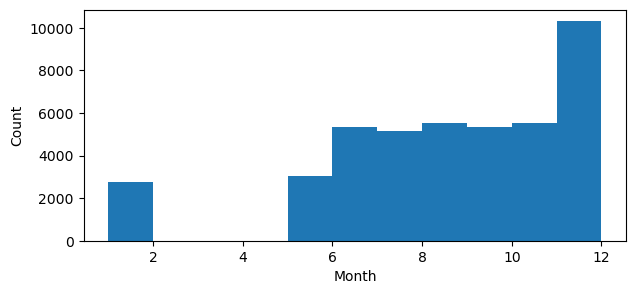

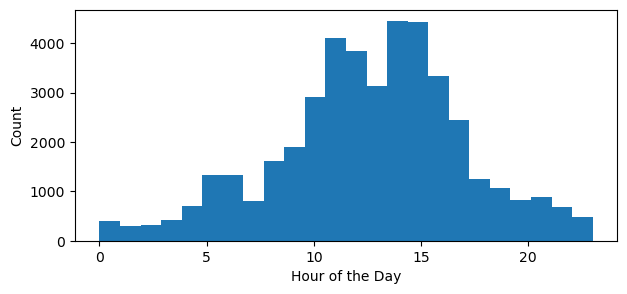

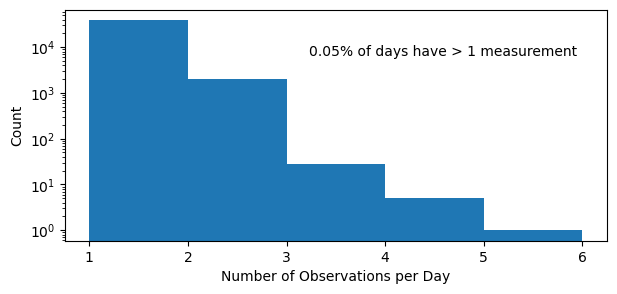

In [11]:
'''
Process and explore 'last_updated' column
'''

# Convert 'last_updated' to datetime, seperate month, day, and hour columns for convenience
data['last_updated'] = pd.to_datetime(data['last_updated'])
data['month'] = [date.month for date in data['last_updated']]
data['day'] = [date.day for date in data['last_updated']]
data['hour'] = [date.hour for date in data['last_updated']]

# Histogram of month of observation
fig, axs = plt.subplots(1, 1, figsize=(7, 3))
plt.hist(data['month'], bins=11)
plt.xlabel('Month')
plt.ylabel('Count')

# Histogram of hour of observation
fig, axs = plt.subplots(1, 1, figsize=(7, 3))
plt.hist(data['hour'], bins=24)
plt.xlabel('Hour of the Day')
plt.ylabel('Count')

# Histogram of number of observations per day
country_days = data['country'] + '_' + data['last_updated'].dt.date.astype(str)
unique_country_days, counts = np.unique(country_days, return_counts=True) 
fig, axs = plt.subplots(1, 1, figsize=(7, 3))
hist = plt.hist(counts, bins=5)
plt.xlabel('Number of Observations per Day')
plt.ylabel('Count')
plt.semilogy()
plt.text(0.45, 0.8, f"{np.round(sum(hist[0][1:])/hist[0][0], 2)}% of days have > 1 measurement", transform=axs.transAxes)

From this a few things are clear:
* The data is not representative of the entire year - Febuary, March, and April have no data, and most data was collected in June - October.
* The hour of data collection is roughly Guassian, peaking around 2pm. However, a non-negligable portion of data was collected significantly earlier and later.  
* While most days only have 1 record associated with them, around 0.06% have 2 or more. 

To further understand the data, I will look at how the observations are distributed amoung the countries represented. 

Text(0, 0.5, 'Count')

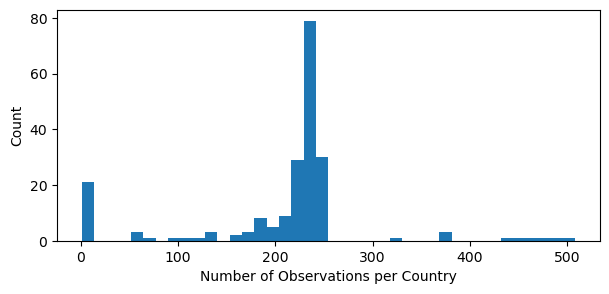

In [12]:
unique_countries, counts = np.unique(data['country'], return_counts=True) 
fig, axs = plt.subplots(1, 1, figsize=(7, 3))
plt.hist(counts, bins=40)
plt.xlabel('Number of Observations per Country')
plt.ylabel('Count')

The countries have a wide range of associated observations. Most have between 150 and 250. 

Text(0, 0.5, 'Temperature (Celcius)')

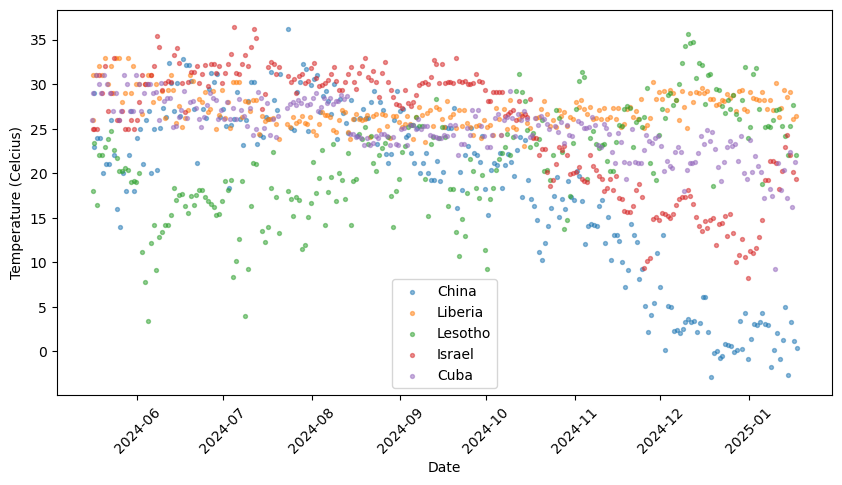

In [ ]:
'''
Plot temperature over the year for random countries
'''
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
for i in range(5):
    country = np.random.choice(unique_countries)
    country_data = data[data['country']==country]
    plt.scatter(country_data['last_updated'], country_data['temperature_celsius'], alpha=0.5, s=8, label=f'{country}')
plt.legend()
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Temperature (Celcius)')

While this data only represents a little over half a year, we can still see the seasonailty in the temperature changes. It is also clear the pattern is reversed for countries in the Northern vs Southern hemispheres, and is near zero for equatorial countries. 

##### Predictive Modeling - Air Quailty Regression

After exploreing the data through the analysis above, I can now begin to form a meaningful research question. First I will examine whether air quailty can be predicted well by temperature, wind, pressure, and percipitation. 

To begin, I will create a dataset for analysis by selecting only the features of interest and isolating the target variable. This set then needs to be divided into seperate sets for model training and testing. 

In [25]:
'''
Construct training and testing sets
'''
X = data_norm[['temperature_celsius', 'wind_kph', 'wind_degree', 'gust_kph', 'pressure_mb', 'precip_mm', 'cloud']]
y = data['air_quality_us-epa-index'] # use non-normalized target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

I can now apply various regression models, performing basic hyperparameter tuning for models with important hyperparameters.  

In [26]:
'''
Train and evaluate supervsied regression models
'''

# Linear Regression (no hyperparameters to tune)
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f'Linear Regression\n\tR^2: {np.round(metrics.r2_score(y_test, pred),2)}\n\tRMSE: {np.round(np.sqrt(np.mean((y_test - pred)**2)),2)}')

# Bayesian Ridge Regression
from sklearn.linear_model import Ridge
info = pd.DataFrame(columns=['alpha', 'R^2', 'RMSE'])
alphas = [1e-1, 1, 10, 100, 1000]
for alpha in alphas:
    model =Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    info.loc[len(info)] = [alpha, metrics.r2_score(y_test, pred), np.sqrt(np.mean((y_test - pred)**2))]
best_alpha = info.loc[info['R^2'].idxmax()]['alpha']
best_R2 = info.loc[info['R^2'].idxmax()]['R^2']
best_RMSE = info.loc[info['R^2'].idxmax()]['RMSE']
print(f'Ridge Regression\n\tOptimal alpha: {best_alpha}\n\tR^2: {np.round(best_R2,2)}, RMSE: {np.round(best_RMSE,2)}')

# Support Vector Regression
from sklearn.svm import SVR
info = pd.DataFrame(columns=['kernel', 'degree', 'R^2', 'RMSE'])
kernels = ['rbf', 'linear', 'poly']
degrees = [2, 3, 4]
for kernel in kernels:
    for degree in degrees:
        model =SVR(kernel=kernel, degree=degree)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        info.loc[len(info)] = [kernel, degree, metrics.r2_score(y_test, pred), np.sqrt(np.mean((y_test - pred)**2))]
best_kernel = info.loc[info['R^2'].idxmax()]['kernel']
best_degree = info.loc[info['R^2'].idxmax()]['degree']
best_R2 = info.loc[info['R^2'].idxmax()]['R^2']
best_RMSE = info.loc[info['R^2'].idxmax()]['RMSE']
print(f'Support Vector Regression\n\tOptimal parameters: kernel {best_kernel}, degree {best_degree}\n\tR^2: {np.round(best_R2,2)}, RMSE: {np.round(best_RMSE,2)}')


Linear Regression
	R^2: 0.06
	RMSE: 0.75
Ridge Regression
	Optimal alpha: 0.1
	R^2: 0.06, RMSE: 0.75
Support Vector Regression
	Optimal parameters: kernel rbf, degree 2
	R^2: 0.08, RMSE: 0.74


Despite exploreing multiple types of models, I achieve very little success in the regression task. The extreamly low R^2 values indicate that the models are not able to fit the data.

##### Additional Predictive Modeling - Latitude Regression

Since seasonal patterns should be strongly affected by latitude (being reversed in the Northern and Southern hemispheres), another interesting question is whether we can predict latitute from time-series temperature measurements. 

To do this, I will need to construct consistent time-series records for each country. This means I need to interpolate the time-stamped data on the same grid. Luckily, the records for each country appear to begin and end on the same date; the only difference is that there are a different total number of records for each country. Since the vast majority of countries have 150-250 time-series points, I will focus on these in my analysis. I will interpolate the data for each country to create time-series records of 200 points each. 


Text(0, 0.5, 'Temperature (Celcius)')

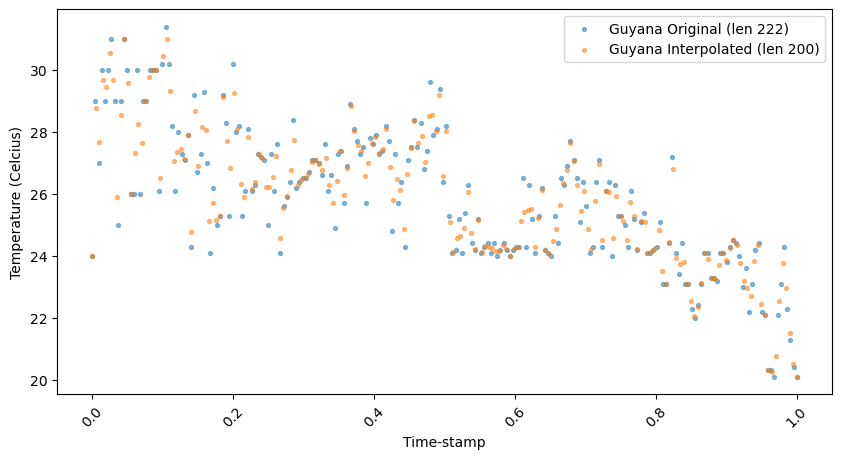

In [15]:
'''
Check interpolation 
'''
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
country = 'Guyana' # np.random.choice(unique_countries)
country_data = data[data['country']==country]
temps = country_data['temperature_celsius']
temps_interp = np.interp(np.linspace(0, 1, 200), np.linspace(0, 1, len(temps)), temps)
plt.scatter(np.linspace(0,1,len(temps)), temps, alpha=0.5, s=8, label=f'{country} Original (len {len(temps)})')
plt.scatter(np.linspace(0,1,200), temps_interp, alpha=0.5, s=8, label=f'{country} Interpolated (len {len(temps_interp)})')
plt.legend()
plt.xticks(rotation = 45)
plt.xlabel('Time-stamp')
plt.ylabel('Temperature (Celcius)')

As shown above, the interpolation maintains the meanginfull trends in temeprature with time. The new "time-stamp" value is a placeholder variable indicating the time. Now I will construct a full dataset of interpolated temperature time-series. 

In [16]:
'''
Construct dataset of latitude and interpolated temperature time-series
'''
temperatures = pd.DataFrame(columns=["latitude"]+[f"T{i}" for i in range(200)])
unique_countries, counts = np.unique(data['country'], return_counts=True) 
for country in unique_countries:
    country_data = data_norm[data_norm['country']==country]
    if len(country_data) < 250 and len(country_data) > 150:
        temps = country_data['temperature_celsius']
        temps_interp = np.interp(np.linspace(0, 1, 200), np.linspace(0, 1, len(temps)), temps)
        lat = np.mean(data[data['country']==country]['latitude']) # should all be the same; use non-normalized data for target
        temperatures.loc[len(temperatures)] = [lat] + list(temps_interp)
print(f"{len(temperatures)} out of {len(unique_countries)} countries have between 150 and 250 time-series data points")
display(temperatures)

165 out of 206 countries have between 150 and 250 time-series data points


,latitude,T0,T1,T2,T3,T4,T5,T6,T7,T8,...,T190,T191,T192,T193,T194,T195,T196,T197,T198,T199
0,34.518566,0.371534,-0.325178,-0.717556,-0.628545,-1.008394,-0.195164,-0.243400,-0.274779,-0.197898,...,-3.014476,-2.686451,-2.441969,-2.404326,-2.452106,-2.500057,-2.551653,-2.346807,-2.353470,-2.507005
1,41.328909,-0.489761,0.561516,0.313219,0.591699,0.397503,0.201029,0.096243,0.303537,0.252853,...,-0.836124,-0.687487,-0.690733,-0.579740,-1.108966,-1.800611,-1.381467,-1.485569,-1.498269,-1.271726
2,36.761370,-0.036448,0.190209,0.152623,0.020501,0.038725,0.264812,-0.034739,0.259117,0.839996,...,-0.695460,-0.944441,-0.763799,-0.558498,-0.776726,-1.162555,-1.334541,-1.536425,-1.428336,-1.396387
3,42.500000,-1.929030,-1.849644,-1.389610,-1.274801,-1.283685,-1.493200,-1.624126,-1.152133,-0.741589,...,-2.470614,-2.662532,-2.312126,-2.078407,-1.680334,-3.019943,-2.379610,-2.241566,-2.620959,-2.405009
4,-8.839173,0.983507,0.653773,0.736349,0.612770,0.530194,0.581448,0.643522,0.643522,0.643522,...,0.883619,0.861523,0.742101,0.729344,0.734982,0.811806,0.790678,0.877525,0.687715,0.552860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,41.901728,0.076881,-0.125288,0.061505,0.043281,0.159457,-0.149776,-0.149776,0.024488,-0.057519,...,-0.893358,-0.901444,-0.964202,-0.891421,-1.233969,-1.494169,-1.615697,-1.796795,-2.044523,-1.373722
161,10.500000,0.303537,0.846830,0.663454,0.600241,0.550126,0.533611,0.563224,0.388733,0.474156,...,-0.526436,0.082348,-0.016402,-0.105697,-0.248013,-0.041060,-0.072496,-0.522165,-0.292547,-0.002449
162,15.352078,0.269539,0.295109,0.212362,0.200802,0.157976,0.251885,0.358664,0.389815,0.399211,...,-0.185027,-0.399098,-0.405021,-0.327286,-0.286396,-0.384519,-0.489761,-0.496310,-0.322274,-0.104445
163,-15.418588,-0.172442,0.018736,-0.039352,0.188728,-0.011846,0.022551,0.071357,0.031151,0.169480,...,-0.628887,-0.439475,0.295735,0.159627,0.294824,0.460489,0.670174,0.593863,0.441354,-0.478428


This dataset can now be divided into training and testing sets to be used in the predictive modeling. 

In [17]:
'''
Construct training and testing sets
'''
X = temperatures.drop(columns=['latitude'])
y = temperatures['latitude']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Finally, we can train and evaluate various regression models. 

In [22]:
'''
Train and evaluate supervsied regression models
'''

# Linear Regression (no hyperparameters to tune)
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f'Linear Regression\n\tR^2: {np.round(metrics.r2_score(y_test, pred),2)}\n\tRMSE: {np.round(np.sqrt(np.mean((y_test - pred)**2)),2)}')

# Bayesian Ridge Regression
from sklearn.linear_model import Ridge
info = pd.DataFrame(columns=['alpha', 'R^2', 'RMSE'])
alphas = [1e-1, 1, 10, 100, 1000]
for alpha in alphas:
    model =Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    info.loc[len(info)] = [alpha, metrics.r2_score(y_test, pred), np.sqrt(np.mean((y_test - pred)**2))]
best_alpha = info.loc[info['R^2'].idxmax()]['alpha']
best_R2 = info.loc[info['R^2'].idxmax()]['R^2']
best_RMSE = info.loc[info['R^2'].idxmax()]['RMSE']
print(f'Ridge Regression\n\tOptimal alpha: {best_alpha}\n\tR^2: {np.round(best_R2,2)}\n\tRMSE: {np.round(best_RMSE,2)}')

# Support Vector Regression
from sklearn.svm import SVR
info = pd.DataFrame(columns=['kernel', 'degree', 'R^2', 'RMSE'])
kernels = ['rbf', 'linear', 'poly']
degrees = [2, 3, 4]
for kernel in kernels:
    for degree in degrees:
        model =SVR(kernel=kernel, degree=degree)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        info.loc[len(info)] = [kernel, degree, metrics.r2_score(y_test, pred), np.sqrt(np.mean((y_test - pred)**2))]
best_kernel = info.loc[info['R^2'].idxmax()]['kernel']
best_degree = info.loc[info['R^2'].idxmax()]['degree']
best_R2 = info.loc[info['R^2'].idxmax()]['R^2']
best_RMSE = info.loc[info['R^2'].idxmax()]['RMSE']
print(f'Support Vector Regression\n\tOptimal parameters: kernel {best_kernel}, degree {best_degree}\n\tR^2: {np.round(best_R2,2)}\n\tRMSE: {np.round(best_MSE,2)}')


Linear Regression
	R^2: 0.37
	RMSE: 18.53
Ridge Regression
	Optimal alpha: 100.0
	R^2: 0.75
	RMSE: 11.72
Support Vector Regression
	Optimal parameters: kernel linear, degree 2
	R^2: 0.7
	RMSE: 11.72


It appears that predicting latitude from weather data can be done with some degree of success. Of the models tested, a Ridge Regression Model with an alpha of 10 works best, achieving an R^2 of 0.88.